<a href="https://colab.research.google.com/github/LinggarM/Poultry-Meat-Freshness-Classification-with-Transfer-Learning-using-ResNet-Architecture/blob/main/Topsus_Poultry_Meat_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**

In [1]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13499477189010488573, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11718170630601586871
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)

# training data
train_files = glob.glob('/content/drive/My Drive/Upload/Akademik/Topsus/dataset_citra_dada_ayam/dataset 200x200/training/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[-1].split('_')[0].strip() for fn in train_files]

# validation data
validation_files = glob.glob('/content/drive/My Drive/Upload/Akademik/Topsus/dataset_citra_dada_ayam/dataset 200x200/validation/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[-1].split('_')[0].strip() for fn in validation_files]

number_of_trainsamples = train_imgs.shape[0]
number_of_testsamples = validation_imgs.shape[0]

print('Train dataset shape:', train_imgs.shape, 
 '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (1000, 224, 224, 3) 	Validation dataset shape: (300, 224, 224, 3)


In [6]:
print(number_of_trainsamples, number_of_testsamples)

1000 300


In [7]:
print(validation_labels)

['busuk', 'busuk', 'segar', 'segar', 'segar', 'busuk', 'segar', 'segar', 'segar', 'busuk', 'segar', 'busuk', 'busuk', 'busuk', 'busuk', 'busuk', 'segar', 'busuk', 'segar', 'busuk', 'busuk', 'segar', 'busuk', 'busuk', 'busuk', 'busuk', 'busuk', 'busuk', 'segar', 'segar', 'busuk', 'segar', 'segar', 'segar', 'busuk', 'busuk', 'segar', 'busuk', 'segar', 'segar', 'busuk', 'busuk', 'segar', 'busuk', 'busuk', 'segar', 'busuk', 'segar', 'busuk', 'busuk', 'segar', 'busuk', 'busuk', 'segar', 'segar', 'busuk', 'busuk', 'segar', 'segar', 'busuk', 'busuk', 'segar', 'segar', 'busuk', 'segar', 'segar', 'segar', 'segar', 'busuk', 'segar', 'busuk', 'segar', 'busuk', 'busuk', 'busuk', 'segar', 'busuk', 'busuk', 'segar', 'segar', 'segar', 'busuk', 'busuk', 'busuk', 'segar', 'busuk', 'busuk', 'busuk', 'busuk', 'segar', 'segar', 'busuk', 'segar', 'busuk', 'busuk', 'busuk', 'segar', 'busuk', 'busuk', 'busuk', 'busuk', 'busuk', 'segar', 'segar', 'segar', 'segar', 'busuk', 'segar', 'segar', 'busuk', 'segar', 

(224, 224, 3)


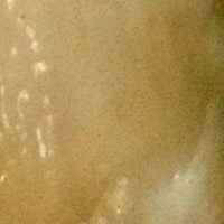

In [8]:
# scale the image
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[0].shape) 
array_to_img(train_imgs[0])

In [9]:
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 

print('Training labels = ', train_labels[495:505], '\nTraining labels (encoded) = ', train_labels_enc[495:505])
print('\nValidation labels = ', validation_labels[95:105], '\nValidation labels (encoded) = ', validation_labels_enc[95:105])

Training labels =  ['busuk', 'busuk', 'busuk', 'busuk', 'busuk', 'segar', 'segar', 'segar', 'segar', 'segar'] 
Training labels (encoded) =  [0 0 0 0 0 1 1 1 1 1]

Validation labels =  ['busuk', 'segar', 'busuk', 'busuk', 'busuk', 'busuk', 'busuk', 'segar', 'segar', 'segar'] 
Validation labels (encoded) =  [0 1 0 0 0 0 0 1 1 1]


In [10]:
# convert train & validation labels to categorical
from tensorflow.keras.utils import to_categorical
train_labels_enc2 = to_categorical(train_labels_enc)
validation_labels_enc2 = to_categorical(validation_labels_enc)

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.1, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['busuk', 'busuk', 'busuk', 'busuk', 'busuk']


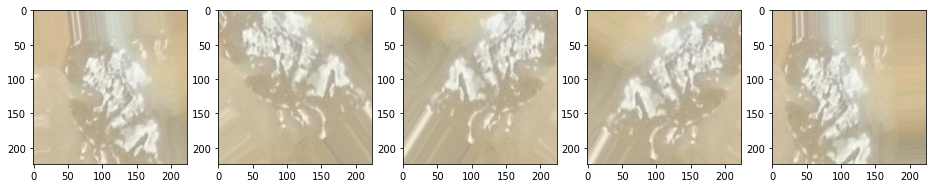

In [12]:
img_id = 100
meat_generator = train_datagen.flow(train_imgs[img_id:img_id+1],
                                    train_labels[img_id:img_id+1],
                                    batch_size=1) 
meat = [next(meat_generator) for i in range(0,5)] 
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in meat]) 
l = [ax[i].imshow(meat[i][0][0]) for i in range(0,5)]

In [13]:
batch = 10
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=batch)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=batch,shuffle=False )

# Create ResNet Model

In [14]:
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152

resnetmodel = ResNet50(weights='imagenet', include_top=True)

102973440/102967424 [==============================] - 1s 0us/step


In [15]:
resnetmodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
for layers in (resnetmodel.layers):
    print(layers)
    layers.trainable = True

In [17]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

X = resnetmodel.layers[-2].output
predictions = Dense(1, activation="sigmoid")(X)
model_final = Model(resnetmodel.input, predictions)
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
from tensorflow.keras import optimizers

model_final.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.0), metrics=["accuracy"])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
history = model_final.fit_generator(generator= train_generator, 
                            validation_data= val_generator, 
                            steps_per_epoch= (number_of_trainsamples/batch), 
                            validation_steps=(number_of_testsamples/batch), 
                            epochs= 200)
model_final.save_weights("/content/drive/My Drive/Upload/Akademik/Topsus/model_resnet_lr1e-3_m0_e200.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
100/100 [==============================] - 51s 155ms/step - loss: 0.4990 - accuracy: 0.7600 - val_loss: 0.9702 - val_accuracy: 0.5000
Epoch 2/200
100/100 [==============================] - 15s 146ms/step - loss: 0.2698 - accuracy: 0.9150 - val_loss: 0.9442 - val_accuracy: 0.5000
Epoch 3/200
100/100 [==============================] - 15s 147ms/step - loss: 0.2525 - accuracy: 0.8950 - val_loss: 2.3241 - val_accuracy: 0.5000
Epoch 4/200
100/100 [==============================] - 15s 147ms/step - loss: 0.2132 - accuracy: 0.9190 - val_loss: 1.7236 - val_accuracy: 0.5000
Epoch 5/200
100/100 [==============================] - 15s 146ms/step - loss: 0.1911 - accuracy: 0.9270 - val_loss: 2.7747 - val_accuracy: 0.5000
Epoch 6/200
100/100 [==============================] - 15s 146ms/step - loss: 0.1738 - accuracy: 0.9360 - val_loss: 2.3059 - val_accuracy: 0.5000
Epoch 7/200
100/100 [==============================] - 15s 147ms/step - loss: 0.1765 - accuracy: 0.9310 - val_loss: 1.0196 -

In [20]:
import pandas as pd

hist_df = pd.DataFrame(history.history) 
hist_csv_file = '/content/drive/My Drive/Upload/Akademik/Topsus/accuracy_loss_resnet_lr1e-3_m0_e200.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

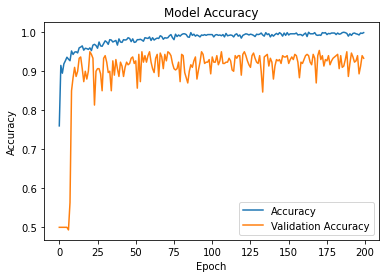

In [21]:
import matplotlib.pyplot as plt
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

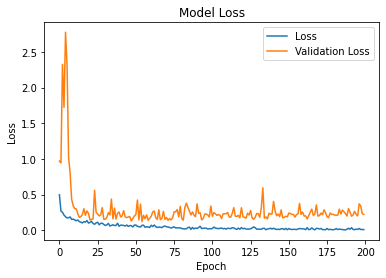

In [22]:
import matplotlib.pyplot as plt
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [23]:
val_generator.reset()
Y_pred = model_final.predict_generator(val_generator, number_of_testsamples/batch)
y_pred = np.where(Y_pred>0.5,1,0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [49]:
y_predict = []
for i in y_pred :
  y_predict.append(i[0])
y_predict

[0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,


In [50]:
from sklearn.metrics import classification_report, confusion_matrix

# Confussion Matrix
confmat = confusion_matrix(validation_labels_enc, y_pred)
print('Confusion Matrix')
print(confmat)

# Save Confussion Matrix
confusionmat_df = pd.DataFrame(confmat) 
confusionmat_csv_file = '/content/drive/My Drive/Upload/Akademik/Topsus/confusionmat_resnet_lr1e-3_m0_e200.csv'
with open(confusionmat_csv_file, mode='w') as f:
    confusionmat_df.to_csv(f)

# Y
for i in y_pred :
  y_pred[i] = y_pred[i][0]

# Save y_test and y_predict
y_test_pred_df = pd.DataFrame(data = {'y_test' : validation_labels_enc, 'y_pred' : y_predict})
y_test_pred_file = '/content/drive/My Drive/Upload/Akademik/Topsus/y_test_pred_resnet_lr1e-3_m0_e200.csv'
with open(y_test_pred_file, mode='w') as f:
    y_test_pred_df.to_csv(f)

# Classification Report
target_name=['busuk','segar']
cls_report = classification_report(validation_labels_enc, y_pred, target_names=target_name)
print('\nClassification Report')
print(cls_report)

# Save Classification Report
cls_report_save = classification_report(validation_labels_enc, y_pred, target_names=target_name, output_dict=True)
cls_report_df = pd.DataFrame(cls_report_save).transpose()
cls_report_file = '/content/drive/My Drive/Upload/Akademik/Topsus/classification_report_resnet_lr1e-3_m0_e200.csv'
with open(cls_report_file, mode='w') as f:
    cls_report_df.to_csv(f)

Confusion Matrix
[[143   7]
 [ 14 136]]

Classification Report
              precision    recall  f1-score   support

       busuk       0.91      0.95      0.93       150
       segar       0.95      0.91      0.93       150

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300

